#### python kernel : 3.7 (lstm)

local : C:\Users\USER\anaconda3\envs

In [6]:
import pandas as pd
import matplotlib.pyplot as plt


In [7]:
#data 불러오기
data=pd.read_excel('C:/Users/USER/Desktop/진행중/FEMS/datamart/moorim/무림페이퍼_15분사용전력_210401-220630.xlsx')   #pip install openpyxl 

In [8]:
data=data.drop(['등록시각'],axis=1)

data['기준시각']=pd.to_datetime(data['기준시각'])
print(data.info(),data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   기준시각         42766 non-null  datetime64[ns]
 1   직전 15분 사용전력  42766 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 668.3 KB
None 기준시각           0
직전 15분 사용전력    0
dtype: int64


In [9]:
#daterange
dates = pd.date_range('2021-04-01 00:00:00', periods=43776, freq='15min')
dates = pd.DataFrame(dates,columns=['기준시각'])

#leftjoin
datas=pd.merge(dates,data,how='left',on='기준시각')

print(datas.isna().sum(), datas['직전 15분 사용전력'].min(),datas['직전 15분 사용전력'].max(),datas['직전 15분 사용전력'].median())

datas
datas.info()

기준시각              0
직전 15분 사용전력    1010
dtype: int64 571.2 8820.0 7341.6
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43776 entries, 0 to 43775
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   기준시각         43776 non-null  datetime64[ns]
 1   직전 15분 사용전력  42766 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 MB


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


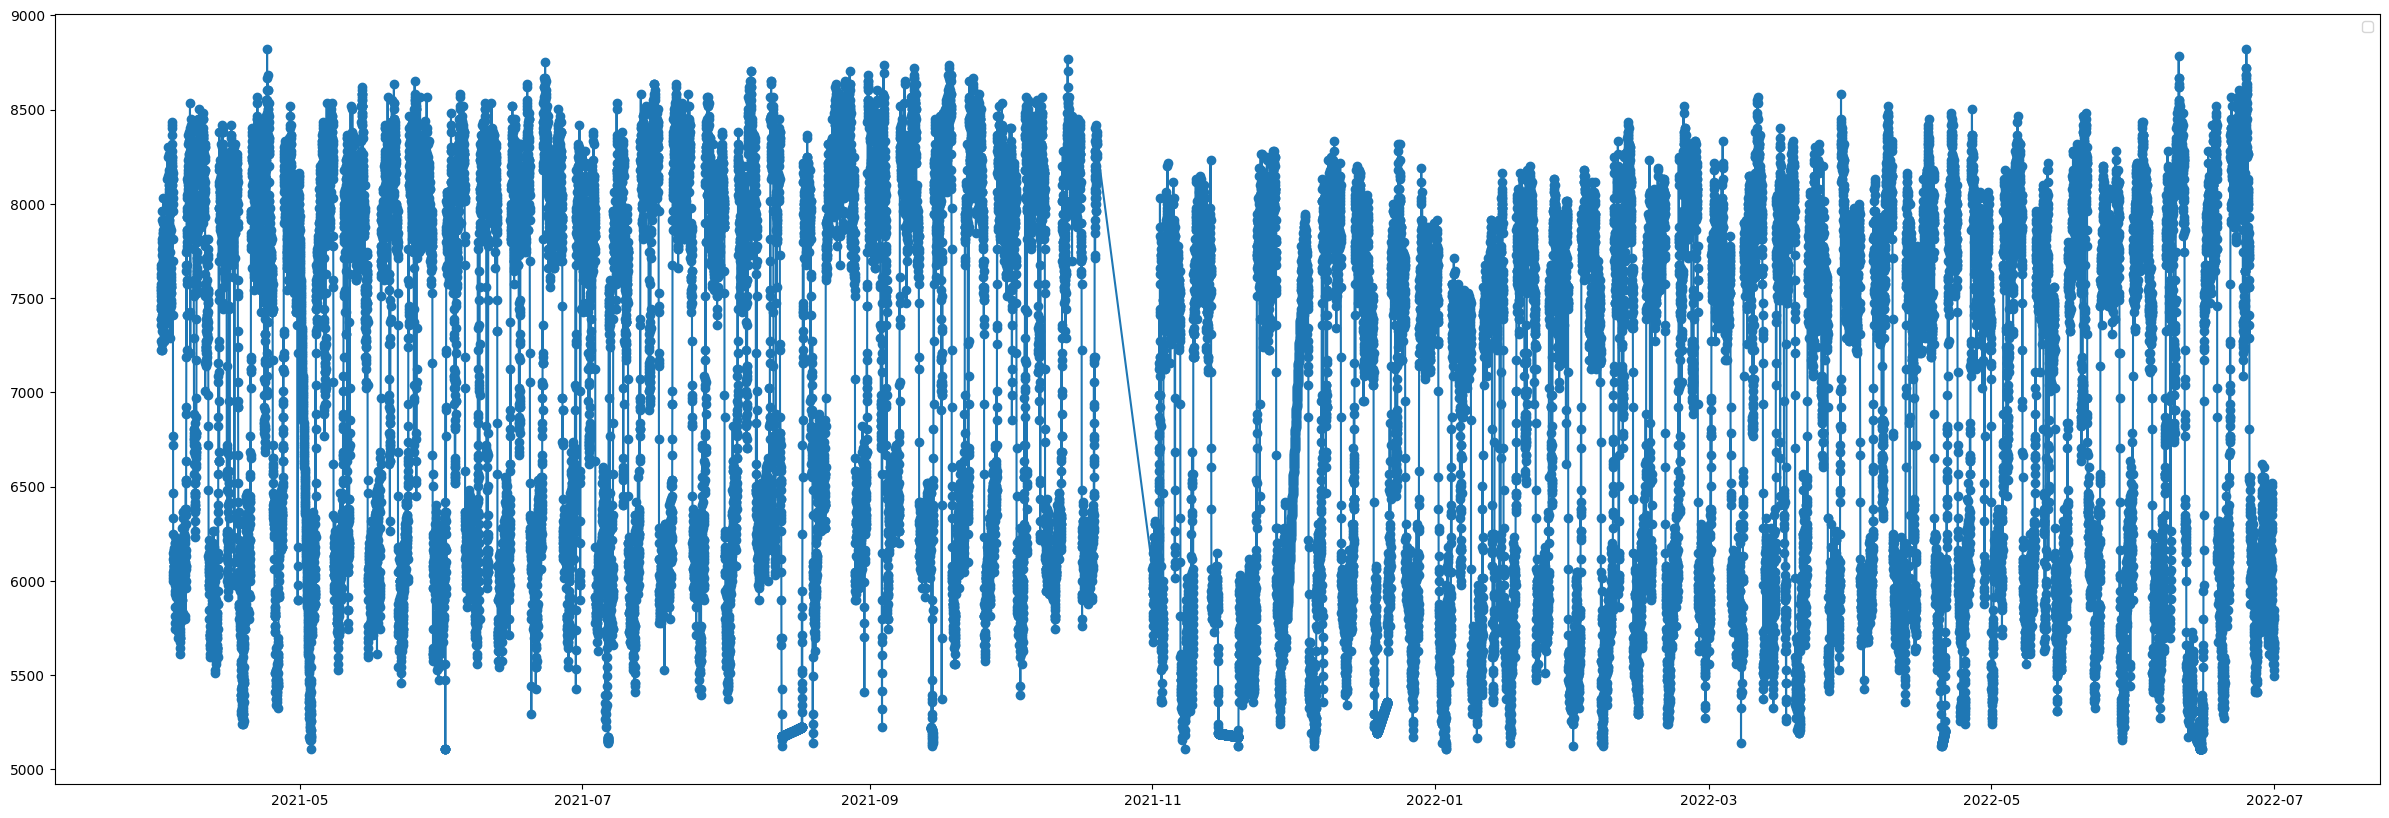

In [10]:
# 10.20, 10.31 (11일치 제거)
Time_name='기준시각'
datas[Time_name]=pd.to_datetime(datas[Time_name])
data1 = datas[(datas[Time_name] < '2021-10-20') ] 
data2= datas[(datas[Time_name] >='2021-11-01')]
data3=pd.concat((data1,data2),axis=0)

# 5100 이하값들은 이전 값들로 대체
import numpy as np
data3.loc[(data3['직전 15분 사용전력'] <= 5100),'직전 15분 사용전력']= np.nan
data3.isna().sum()



# 선형 보간(linear) : 이상치,5100이하 na값 후
from scipy import interpolate
data3['직전 15분 사용전력']=data3['직전 15분 사용전력'].interpolate()

#보간후
plt.figure(figsize=(30,10))
kws = dict(marker='o')
plt.plot(data3['기준시각'],data3['직전 15분 사용전력'], **kws)   
plt.legend()
plt.show()

In [11]:
# # 10.20, 10.25 (5일치 제거)
# Time_name='기준시각'
# datas[Time_name]=pd.to_datetime(datas[Time_name])
# data1 = datas[(datas[Time_name] < '2021-10-20') ] 
# data2= datas[(datas[Time_name] >= '2021-10-26')]
# data3=pd.concat((data1,data2),axis=0)

# plt.figure(figsize=(30,10))
# kws = dict(marker='o')
# plt.plot(data3['기준시각'],data3['직전 15분 사용전력'], **kws)   
# plt.legend()
# plt.show()

In [12]:
#feature생성 (diff)

def gen_feature_diff(data,Y_name,feature,i) :  # (data : dataframe, Y_name : 'dataframe 내 Y 변수 명', feature : 'dataframe에 생성하고 싶은 변수 명',i : diff 차수 ) 
    #diff data
    data[feature]=data[Y_name].diff(i).shift(1)   #필요시 column명 수정 필요

    return data


for i in range(1,97):
    gen_feature_diff(data3,'직전 15분 사용전력','d_'+str(i),i)


In [13]:
# train_test split
def train_test_split(data,Time_name,train_cut_date,val_cut_date,end_time,want_val): # (data : dataframe , Time_name : 'dataframe 내 Time 변수명',want_val : validation set을 원할 경우'Y')

    data[Time_name]=pd.to_datetime(data[Time_name])
    df_train = data[data[Time_name] < train_cut_date ]
    df_test = data[(data[Time_name] >= val_cut_date) & (data[Time_name] <= end_time )] 
    print('train_df=',min(df_train[Time_name]),'~',max(df_train[Time_name]),',',len(df_train))
    print('test_df=',min(df_test[Time_name]),'~',max(df_test[Time_name]),',',len(df_test))

    if want_val=="Y":
        df_val= data[(data[Time_name] >= train_cut_date ) & (data[Time_name] < val_cut_date )]
        print('val_df=',min(df_val[Time_name]),'~',max(df_val[Time_name]),',',len(df_val))
        return (df_train,df_val,df_test) 

    return (df_train,df_test)  

df_train,df_test=train_test_split(data3,Time_name='기준시각',train_cut_date='2022-06-30',val_cut_date='2022-06-30',end_time='2022-06-30 23:45:00',want_val='N') 

train_df= 2021-04-01 00:00:00 ~ 2022-06-29 23:45:00 , 42528
test_df= 2022-06-30 00:00:00 ~ 2022-06-30 23:45:00 , 96


In [14]:
df_train

,기준시각,직전 15분 사용전력,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,...,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96
0,2021-04-01 00:00:00,7224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-04-01 00:15:00,7274.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-04-01 00:30:00,7442.4,50.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-04-01 00:45:00,7392.0,168.0,218.4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-04-01 01:00:00,7576.8,-50.4,117.6,168.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43675,2022-06-29 22:45:00,5678.4,-16.8,-252.0,-336.0,-319.2,-386.4,-268.8,-201.6,-369.6,...,-756.0,-621.6,-688.8,-638.4,-697.2,-571.2,-588.0,-688.8,-772.8,-789.6
43676,2022-06-29 23:00:00,5611.2,-50.4,-67.2,-302.4,-386.4,-369.6,-436.8,-319.2,-252.0,...,-823.2,-806.4,-672.0,-739.2,-688.8,-747.6,-621.6,-638.4,-739.2,-823.2
43677,2022-06-29 23:15:00,5896.8,-67.2,-117.6,-134.4,-369.6,-453.6,-436.8,-504.0,-386.4,...,-722.4,-890.4,-873.6,-739.2,-806.4,-756.0,-814.8,-688.8,-705.6,-806.4
43678,2022-06-29 23:30:00,5930.4,285.6,218.4,168.0,151.2,-84.0,-168.0,-151.2,-218.4,...,-571.2,-436.8,-604.8,-588.0,-453.6,-520.8,-470.4,-529.2,-403.2,-420.0


In [15]:
df_train.rename(columns={'기준시각':'date','직전 15분 사용전력':'value'},inplace=True)
df_train
ts=df_train.set_index('date')

c:\Users\USER\anaconda3\envs\lstm\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
# 데이터 분리(train,val), 결측치 21.4.1 제거
#train : 2021.04.02 ~ 2022.03.31
#val: 2022.04.01~2022.06.27
#test : 2022.06.28~2022.06.29

ts=ts[ts.index > '2021-04-01 23:45:00' ]
train=ts[ts.index <= '2022-03-31 23:45:00' ]
val=ts[(ts.index >= '2022-04-01 00:00:00') & (ts.index < '2022-06-28 00:00:00') ]
test=ts[ts.index >= '2022-06-28 00:00:00' ]
print(ts.shape,train.shape,val.shape,test.shape)

(42432, 97) (33792, 97) (8448, 97) (192, 97)


In [17]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
import numpy as np

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))  
s_data = scaler.fit_transform(ts)  # 학습을 위해 데이터를 0~1의 값으로 정규화한다.   #np.array(ts['value']).reshape(-1,1)    ts:dataframe

In [18]:
s_data.shape

(42432, 97)

In [19]:
s_train=s_data[0:len(train)]
s_val=s_data[len(train):len(train)+len(val)]
s_test=s_data[len(train)+len(val):]
print(s_train.shape,s_val.shape,s_test.shape)

(33792, 97) (8448, 97) (192, 97)


In [20]:
def create_dataset(signal_data, look_back=1):  
    import numpy as np
    x_arr, y_arr = [], []
    for i in range(len(signal_data) - look_back):
        x_arr.append(signal_data[i:(i + look_back), 0])
        y_arr.append(signal_data[i + look_back, 0])

    x_arr = np.array(x_arr)
    x_arr = np.reshape(x_arr, (x_arr.shape[0], x_arr.shape[1], 1))
    return x_arr, np.array(y_arr)

In [21]:

# 학습용 데이터 세트 생성
# look_back 파라미터의 값에 따라 다음 값을 예상하기 위해 과거의 데이터를 몇 건 사용할지 결정된다.
look_back= 96
x_train, y_train = create_dataset(s_train, look_back)  
x_val, y_val = create_dataset(s_val, look_back)  
x_test, y_test = create_dataset(s_test, look_back)  

In [34]:
x_train.shape

(33696, 96, 1)

In [37]:
x_test.shape

(96, 96, 1)

In [22]:
#parameter
batch_size=32

In [26]:
# 학습 모델 구성
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
# import autokeras as ak
import tensorflow as tf

model = Sequential()  
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))  
model.add(Dropout(0.2)) # overfitting을 막기 위해 20% 가량을 drop  
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True))  
model.add(Dropout(0.2))  
model.add(Dense(1))

# 학습 과정 설정
model.compile(loss='mean_squared_error', optimizer='adam')



In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (32, 96, 32)              4352      
                                                                 
 dropout (Dropout)           (32, 96, 32)              0         
                                                                 
 lstm_1 (LSTM)               (32, 32)                  8320      
                                                                 
 dropout_1 (Dropout)         (32, 32)                  0         
                                                                 
 dense (Dense)               (32, 1)                   33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [30]:
# 모델 학습
from tensorflow import keras
import pickle

home_path='C:/Users/USER/Documents/GitHub/Time_Series_models/FEMS_predict/LSTM/'
path_checkpoint = home_path + "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=20, mode='auto')

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)


hist = model.fit(x_train, y_train, epochs=100, batch_size=batch_size, validation_data=(x_val, y_val),callbacks=[es_callback, modelckpt_callback])

model.save(home_path + 'save_state_lstm.h5')  

Epoch 1/100
1053/1053 [==============================] - ETA: 0s - loss: 0.0043
Epoch 1: val_loss improved from inf to 0.00167, saving model to C:/Users/USER/Documents/GitHub/Time_Series_models/FEMS_predict/LSTM\model_checkpoint.h5
1053/1053 [==============================] - 33s 31ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 2/100
1053/1053 [==============================] - ETA: 0s - loss: 0.0030
Epoch 2: val_loss improved from 0.00167 to 0.00129, saving model to C:/Users/USER/Documents/GitHub/Time_Series_models/FEMS_predict/LSTM\model_checkpoint.h5
1053/1053 [==============================] - 36s 34ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 3/100
1052/1053 [============================>.] - ETA: 0s - loss: 0.0024
Epoch 3: val_loss improved from 0.00129 to 0.00118, saving model to C:/Users/USER/Documents/GitHub/Time_Series_models/FEMS_predict/LSTM\model_checkpoint.h5
1053/1053 [==============================] - 37s 35ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 4/100
1053/

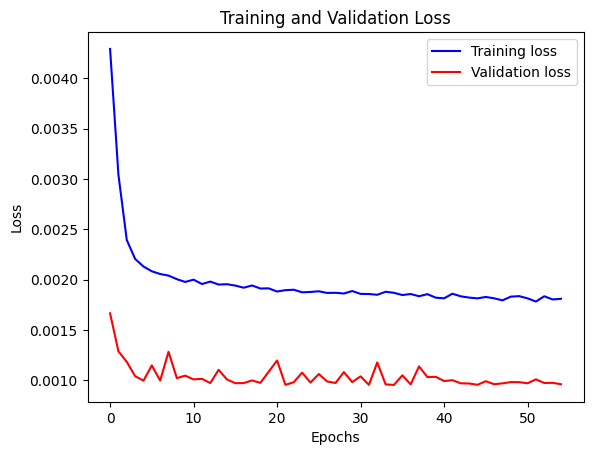

In [31]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(hist, "Training and Validation Loss")

In [ ]:
# df_test.rename(columns={'기준시각':'date','직전 15분 사용전력':'value'},inplace=True)
# df_test
# ts_test=df_test.set_index('date')
# ts_test_f=ts_test.drop(['value'],axis=1)
# s_test = scaler.fit_transform(ts_test_f) 
# s_test

In [23]:
#MODEL LOAD
from keras.models import load_model
model=load_model('C:/Users/USER/Documents/GitHub/Time_Series_models/FEMS_predict/LSTM/save_state_lstm.h5')

In [24]:
# 모델 사용
predictions = model.predict(x_test)   #, batch_size


3/3 [==============================] - 1s 38ms/step


In [25]:
predictions.shape

results=pd.DataFrame(predictions,columns=['predict'])

In [26]:
s_test_df=pd.DataFrame(s_test)
s_fake=s_test_df.iloc[:96,1:]

In [27]:
result=pd.concat((results,s_fake),axis=1)

In [28]:
result

,predict,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,0.360567,0.613426,0.589219,0.570690,0.502816,0.477636,0.517405,0.513045,0.521621,0.507962,...,0.552814,0.567590,0.577305,0.575808,0.574168,0.553606,0.542614,0.544023,0.573173,0.581304
1,0.333694,0.594907,0.572491,0.537931,0.494771,0.479233,0.468354,0.505004,0.500363,0.487261,...,0.541149,0.542769,0.560110,0.558735,0.567529,0.554923,0.533492,0.529651,0.542399,0.558553
2,0.351882,0.625000,0.581784,0.544828,0.485117,0.492013,0.490506,0.476054,0.513445,0.487261,...,0.538556,0.547994,0.552174,0.558735,0.567529,0.565457,0.551736,0.537491,0.545075,0.545170
3,0.329019,0.625000,0.605948,0.553448,0.491553,0.482428,0.503165,0.498570,0.484012,0.500000,...,0.548926,0.545382,0.557465,0.550856,0.567529,0.565457,0.562160,0.555782,0.553103,0.547847
4,0.375010,0.611111,0.594796,0.565517,0.489944,0.479233,0.484177,0.501787,0.497093,0.461783,...,0.548926,0.547994,0.546884,0.548229,0.551596,0.557556,0.554342,0.558395,0.563807,0.547847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.178764,0.620370,0.605948,0.596552,0.546259,0.539936,0.541139,0.540386,0.539608,0.509554,...,0.611143,0.610700,0.620954,0.619147,0.611345,0.602328,0.593435,0.605430,0.611975,0.596025
92,0.162433,0.615741,0.594796,0.568966,0.533387,0.536741,0.544304,0.543603,0.542878,0.519108,...,0.616328,0.613313,0.615663,0.613893,0.623295,0.603644,0.593435,0.592365,0.617327,0.609408
93,0.146446,0.597222,0.576208,0.544828,0.494771,0.511182,0.528481,0.533953,0.533067,0.509554,...,0.605958,0.608088,0.607727,0.598134,0.607362,0.604961,0.584313,0.581912,0.593243,0.604055
94,0.218030,0.592593,0.557621,0.524138,0.469027,0.469649,0.500000,0.514653,0.519985,0.496815,...,0.590404,0.595024,0.599791,0.587628,0.588774,0.586526,0.583010,0.570154,0.579863,0.577289


In [29]:
real_predictions = scaler.inverse_transform(result)  # 0~1의 값으로 정규화된 값을 원래의 크기로 되돌린다.  
real_pred=pd.DataFrame(real_predictions)
real_pred.index=df_test.index

In [30]:
real_pred

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
43680,6445.914388,-25.2,-42.0,25.2,-25.2,-126.0,42.0,-8.4,8.4,25.2,...,310.8,378.0,394.8,411.6,361.2,260.4,226.8,226.8,327.6,378.0
43681,6346.138792,-92.4,-117.6,-134.4,-67.2,-117.6,-218.4,-50.4,-100.8,-84.0,...,235.2,218.4,285.6,302.4,319.2,268.8,168.0,134.4,134.4,235.2
43682,6413.668857,16.8,-75.6,-100.8,-117.6,-50.4,-100.8,-201.6,-33.6,-84.0,...,218.4,252.0,235.2,302.4,319.2,336.0,285.6,184.8,151.2,151.2
43683,6328.782776,16.8,33.6,-58.8,-84.0,-100.8,-33.6,-84.0,-184.8,-16.8,...,285.6,235.2,268.8,252.0,319.2,336.0,352.8,302.4,201.6,168.0
43684,6499.538506,-33.6,-16.8,0.0,-92.4,-117.6,-134.4,-67.2,-117.6,-218.4,...,285.6,252.0,201.6,235.2,218.4,285.6,302.4,319.2,268.8,168.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43771,5770.914926,0.0,33.6,151.2,201.6,201.6,168.0,134.4,100.8,33.6,...,688.8,655.2,672.0,688.8,596.4,571.2,554.4,621.6,571.2,470.4
43772,5710.280019,-16.8,-16.8,16.8,134.4,184.8,184.8,151.2,117.6,84.0,...,722.4,672.0,638.4,655.2,672.0,579.6,554.4,537.6,604.8,554.4
43773,5650.925223,-84.0,-100.8,-100.8,-67.2,50.4,100.8,100.8,67.2,33.6,...,655.2,638.4,588.0,554.4,571.2,588.0,495.6,470.4,453.6,520.8
43774,5916.702690,-100.8,-184.8,-201.6,-201.6,-168.0,-50.4,0.0,0.0,-33.6,...,554.4,554.4,537.6,487.2,453.6,470.4,487.2,394.8,369.6,352.8


In [31]:
pd.DataFrame(real_pred.iloc[:,0])

,0
43680,6445.914388
43681,6346.138792
43682,6413.668857
43683,6328.782776
43684,6499.538506
...,...
43771,5770.914926
43772,5710.280019
43773,5650.925223
43774,5916.702690


In [32]:
result_d=df_test[['기준시각','직전 15분 사용전력']]
result_df=pd.concat((result_d,pd.DataFrame(real_pred.iloc[:,0])),axis=1,ignore_index=True)

In [33]:
result_df

,0,1,2
43680,2022-06-30 00:00:00,5846.4,6445.914388
43681,2022-06-30 00:15:00,5812.8,6346.138792
43682,2022-06-30 00:30:00,5745.6,6413.668857
43683,2022-06-30 00:45:00,5712.0,6328.782776
43684,2022-06-30 01:00:00,5745.6,6499.538506
...,...,...,...
43771,2022-06-30 22:45:00,5628.0,5770.914926
43772,2022-06-30 23:00:00,5560.8,5710.280019
43773,2022-06-30 23:15:00,5493.6,5650.925223
43774,2022-06-30 23:30:00,5527.2,5916.702690


In [35]:
result_df.columns=[['date','real','predict']]

In [43]:
result_df

,date,real,predict
43680,2022-06-30 00:00:00,5846.4,6445.914388
43681,2022-06-30 00:15:00,5812.8,6346.138792
43682,2022-06-30 00:30:00,5745.6,6413.668857
43683,2022-06-30 00:45:00,5712.0,6328.782776
43684,2022-06-30 01:00:00,5745.6,6499.538506
...,...,...,...
43771,2022-06-30 22:45:00,5628.0,5770.914926
43772,2022-06-30 23:00:00,5560.8,5710.280019
43773,2022-06-30 23:15:00,5493.6,5650.925223
43774,2022-06-30 23:30:00,5527.2,5916.702690


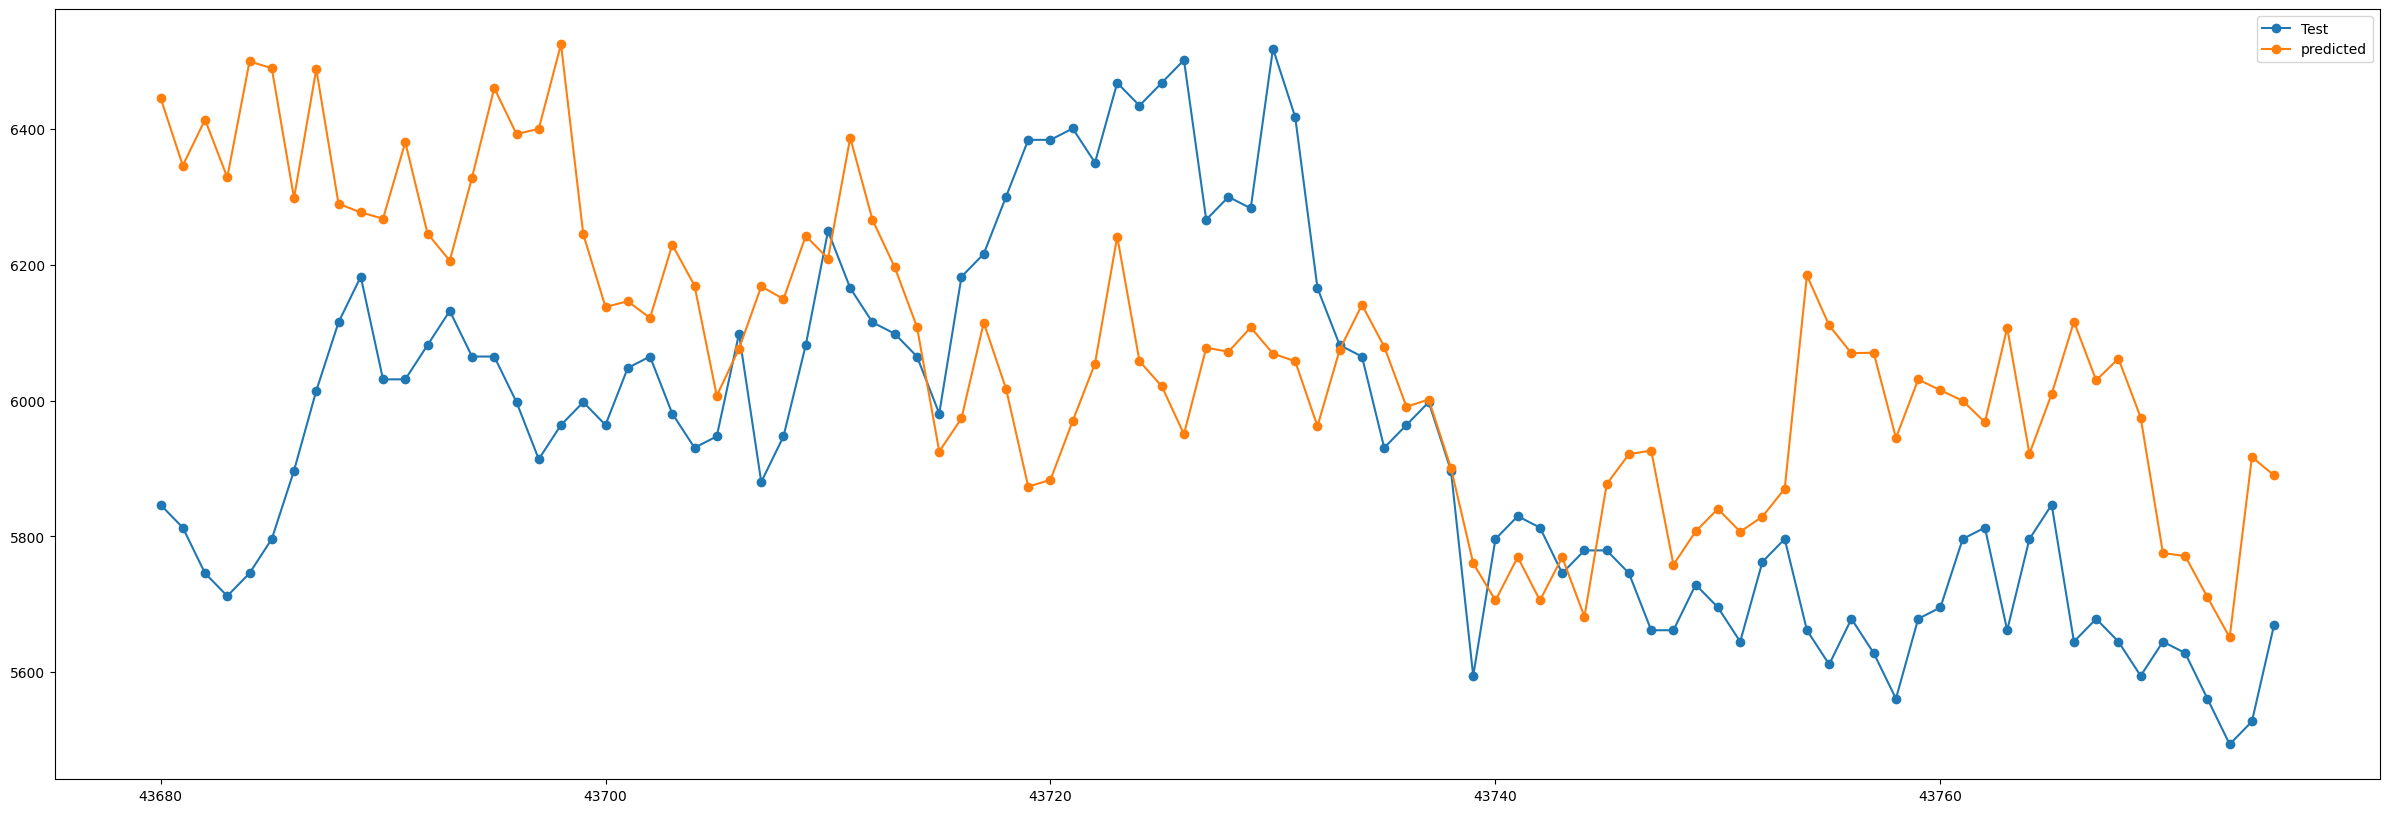

In [41]:
def predict_graph(test,prediction) : #train,
    plt.figure(figsize=(30,10))
    kws = dict(marker='o')
    # plt.plot(train, label='Train', **kws)   
    plt.plot(test, label='Test', **kws)   
    plt.plot(prediction,label='predicted', **kws)
    plt.legend()
    return plt.show()

predict_graph(result_df['real'],result_df['predict'])#.shift(-1)

In [45]:
#mape
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

mape(result_df['real'],result_df['predict'])

4.338264797055208

# tunning 

# 날짜별 결측치 확인

In [4]:
#daterange
dates = pd.date_range('2021-04-01 00:00:00', periods=43776, freq='15min')
dates = pd.DataFrame(dates,columns=['기준시각'])

#leftjoin
datas=pd.merge(dates,data,how='left',on='기준시각')

print(datas.isna().sum(), datas['직전 15분 사용전력'].min(),datas['직전 15분 사용전력'].max(),datas['직전 15분 사용전력'].median())

datas
datas.info()

기준시각              0
직전 15분 사용전력    1010
dtype: int64 571.2 8820.0 7341.6
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43776 entries, 0 to 43775
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   기준시각         43776 non-null  datetime64[ns]
 1   직전 15분 사용전력  42766 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 MB


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


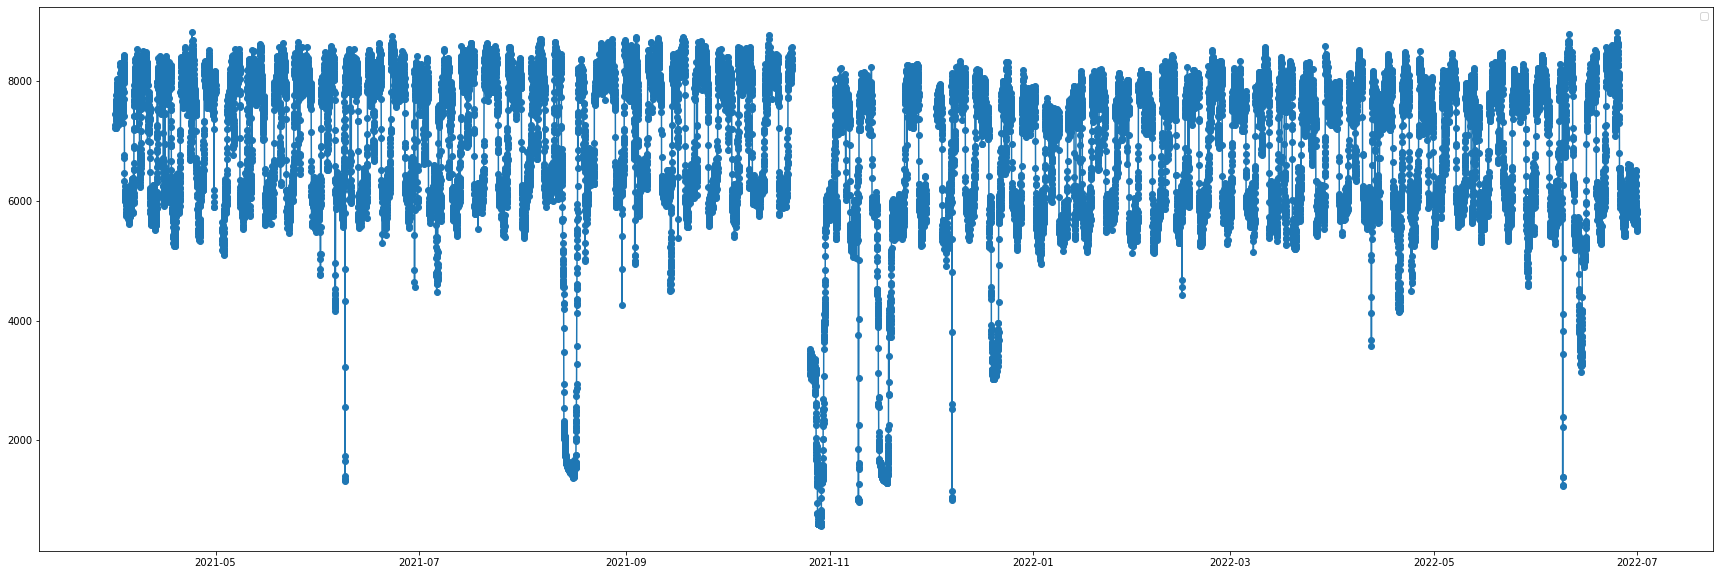

In [12]:
# 기존 데이터 그래프(결측 처리 전)
import matplotlib.pyplot as plt

plt.figure(figsize=(30,10))
kws = dict(marker='o')
plt.plot(datas['기준시각'],datas['직전 15분 사용전력'], **kws)   
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


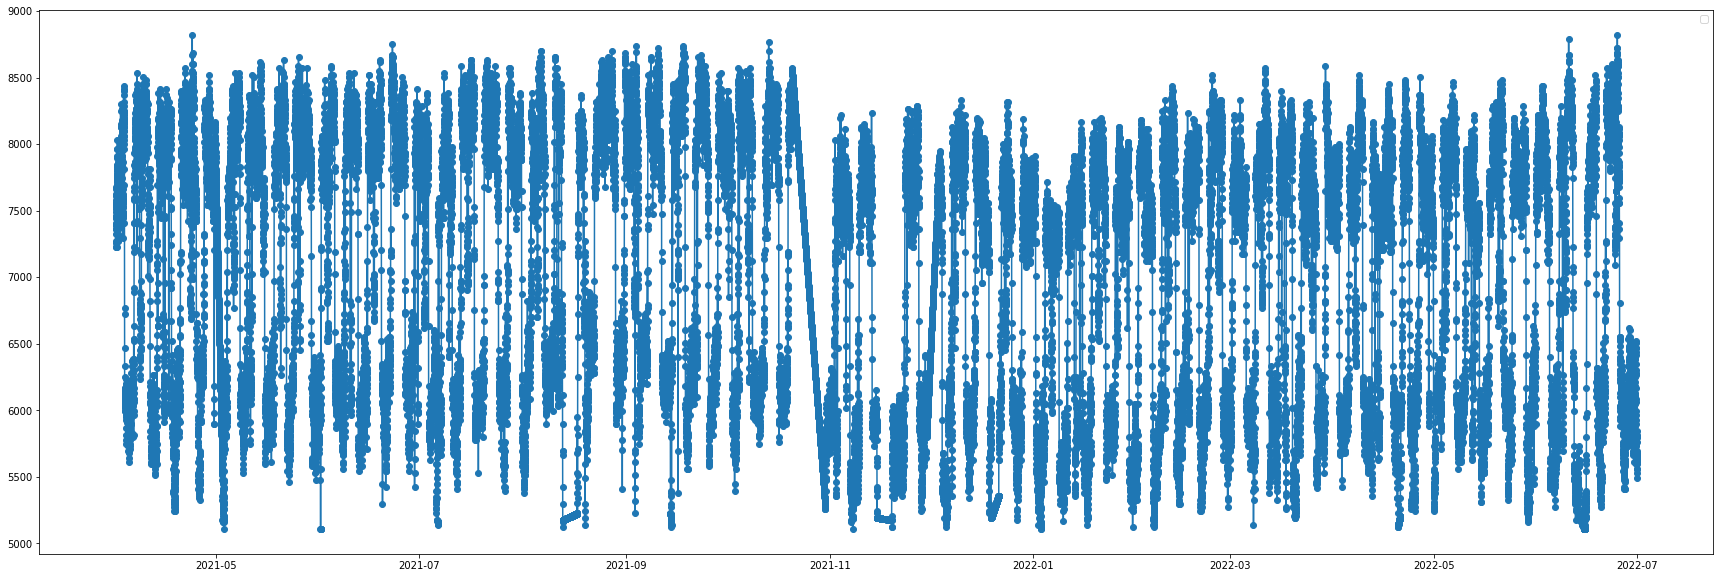

In [5]:
# 5100 이하값들은 이전 값들로 대체
import numpy as np
datas.loc[(datas['직전 15분 사용전력'] <= 5100),'직전 15분 사용전력']= np.nan
datas.isna().sum()

# 선형 보간(linear) : 이상치,5100이하 na값 후
from scipy import interpolate
datas['직전 15분 사용전력']=datas['직전 15분 사용전력'].interpolate()

#보간후
plt.figure(figsize=(30,10))
kws = dict(marker='o')
plt.plot(datas['기준시각'],datas['직전 15분 사용전력'], **kws)   
plt.legend()
plt.show()


module 불러오기 (git 연동 & clone 후 )


('/home/ykkim/Baseline_Analysis/4. Supervised_model/neural_prophet_module.py')

In [6]:
import sys
sys.path.append('/home/ykkim/Baseline_Analysis/4. Supervised_model/' )  #모듈 저장 위치 지정 
print(sys.path)

['/home/ykkim/.jupyter', '/home/ykkim/anaconda3/envs/NeuralProphet/lib/python39.zip', '/home/ykkim/anaconda3/envs/NeuralProphet/lib/python3.9', '/home/ykkim/anaconda3/envs/NeuralProphet/lib/python3.9/lib-dynload', '', '/home/ykkim/anaconda3/envs/NeuralProphet/lib/python3.9/site-packages', '/home/ykkim/Baseline_Analysis/4. Supervised_model/']


In [7]:
import neural_prophet_module as NP

In [8]:
#lag, diff feature 생성
for i in range(1,97):
    NP.gen_feature_lag(datas,'직전 15분 사용전력','l_'+str(i),i)


In [27]:
#na값 삭제
datas=datas.dropna()
datas



,기준시각,직전 15분 사용전력,l_1,l_2,l_3,l_4,l_5,l_6,l_7,l_8,...,l_87,l_88,l_89,l_90,l_91,l_92,l_93,l_94,l_95,l_96
96,2021-04-02 00:00:00,7660.8,7560.0,7543.2,7492.8,7526.4,7425.6,7308.0,7492.8,7442.4,...,7392.0,7610.4,7677.6,7660.8,7492.8,7576.8,7392.0,7442.4,7274.4,7224.0
97,2021-04-02 00:15:00,7660.8,7660.8,7560.0,7543.2,7492.8,7526.4,7425.6,7308.0,7492.8,...,7358.4,7392.0,7610.4,7677.6,7660.8,7492.8,7576.8,7392.0,7442.4,7274.4
98,2021-04-02 00:30:00,7828.8,7660.8,7660.8,7560.0,7543.2,7492.8,7526.4,7425.6,7308.0,...,7459.2,7358.4,7392.0,7610.4,7677.6,7660.8,7492.8,7576.8,7392.0,7442.4
99,2021-04-02 00:45:00,7778.4,7828.8,7660.8,7660.8,7560.0,7543.2,7492.8,7526.4,7425.6,...,7560.0,7459.2,7358.4,7392.0,7610.4,7677.6,7660.8,7492.8,7576.8,7392.0
100,2021-04-02 01:00:00,7694.4,7778.4,7828.8,7660.8,7660.8,7560.0,7543.2,7492.8,7526.4,...,7627.2,7560.0,7459.2,7358.4,7392.0,7610.4,7677.6,7660.8,7492.8,7576.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43771,2022-06-30 22:45:00,5628.0,5644.8,5594.4,5644.8,5678.4,5644.8,5846.4,5796.0,5661.6,...,5745.6,5712.0,5745.6,5812.8,5846.4,5922.0,5930.4,5896.8,5611.2,5678.4
43772,2022-06-30 23:00:00,5560.8,5628.0,5644.8,5594.4,5644.8,5678.4,5644.8,5846.4,5796.0,...,5796.0,5745.6,5712.0,5745.6,5812.8,5846.4,5922.0,5930.4,5896.8,5611.2
43773,2022-06-30 23:15:00,5493.6,5560.8,5628.0,5644.8,5594.4,5644.8,5678.4,5644.8,5846.4,...,5896.8,5796.0,5745.6,5712.0,5745.6,5812.8,5846.4,5922.0,5930.4,5896.8
43774,2022-06-30 23:30:00,5527.2,5493.6,5560.8,5628.0,5644.8,5594.4,5644.8,5678.4,5644.8,...,6014.4,5896.8,5796.0,5745.6,5712.0,5745.6,5812.8,5846.4,5922.0,5930.4


In [18]:
# train_test split
df_train,df_test=NP.train_test_split(datas,Time_name='기준시각',train_cut_date='2022-06-30',val_cut_date='2022-06-30',end_time='2022-06-30 23:45:00',want_val='N')  #validation set은 추후에 분리

WARNING - (py.warnings._showwarnmsg) - /home/ykkim/Baseline_Analysis/4. Supervised_model/neural_prophet_module.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[Time_name]=pd.to_datetime(data[Time_name])



train_df= 2021-04-02 00:00:00 ~ 2022-06-29 23:45:00 , 43584
test_df= 2022-06-30 00:00:00 ~ 2022-06-30 23:45:00 , 96


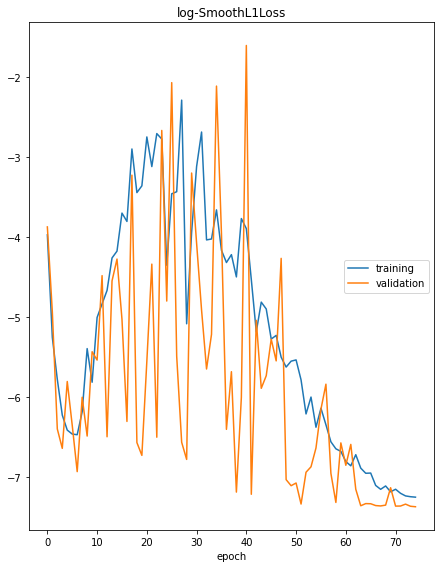

log-SmoothL1Loss
	training         	 (min:   -7.247, max:   -2.285, cur:   -7.247)
	validation       	 (min:   -7.366, max:   -1.603, cur:   -7.366)
SmoothL1Loss:  0.0007125521871857786
MAE(Train):  85.0779814725077
MAE(val):  84.25474893920955


In [19]:
#모델 학습
model, metrics= NP.NP_model(df_train,df_test,Time_name='기준시각',Y_name='직전 15분 사용전력',num_futureregressor=96,val_p=0.2)   # pip install livelossplot

INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.998% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 15T
WARNING - (py.warnings._showwarnmsg) - /home/ykkim/anaconda3/envs/NeuralProphet/lib/python3.9/site-packages/neuralprophet/forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.998% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 15T
INFO - (NP.df_utils._infer_frequency) - Major frequency 15T corresponds to 99.998% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 15T
WARNING - (py.warnings._showwarnmsg) - /home/ykkim/anaconda3/envs/NeuralProphet/lib/python3.9/site-packages/neuralprophet/forecaster

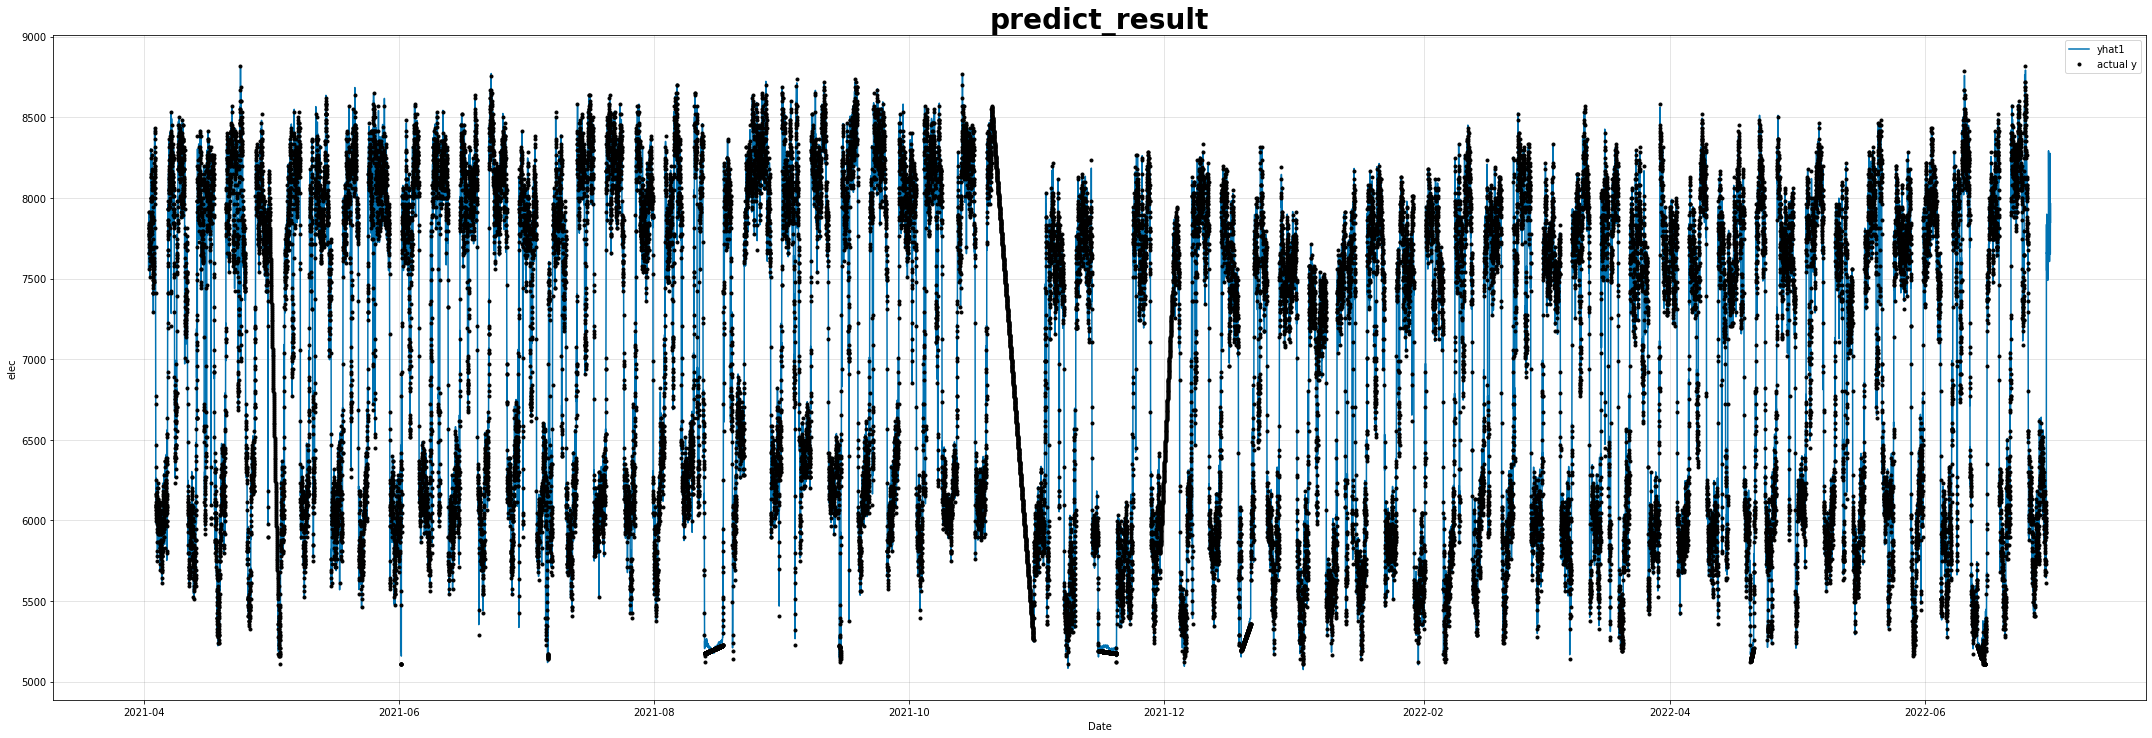

In [20]:
#train 후 예측
forecast=NP.NP_model_predict(df_train,model,num_futureregressor=96,predict_period=96) #하루치 예측

In [21]:
forecast.tail(96)

,ds,y,yhat1,residual1,trend,season_weekly,season_daily,future_regressors_additive,future_regressor_l_1,future_regressor_l_10,...,future_regressor_l_88,future_regressor_l_89,future_regressor_l_9,future_regressor_l_90,future_regressor_l_91,future_regressor_l_92,future_regressor_l_93,future_regressor_l_94,future_regressor_l_95,future_regressor_l_96
43584,2022-06-30 00:00:00,NaN,7560.916016,NaN,5137.695801,0.124957,0.158764,2414.568359,2695.572998,-24.883743,...,26.813967,-46.622253,-36.938751,19.329588,-0.700449,14.171154,-37.687000,27.760458,-4.029155,15.471639
43585,2022-06-30 00:15:00,NaN,7659.610352,NaN,5137.695801,0.116749,0.088258,2515.662354,2806.349854,-22.957258,...,24.474493,-45.403374,-35.905499,19.456755,-0.749776,13.689142,-40.735214,27.161310,-4.341493,15.840010
43586,2022-06-30 00:30:00,NaN,7656.448242,NaN,5137.696289,0.108783,0.010057,2515.127930,2806.349854,-22.315098,...,24.114573,-41.442005,-36.680439,18.948082,-0.754709,14.653167,-39.349663,29.358181,-4.247792,17.067919
43587,2022-06-30 00:45:00,NaN,7835.504883,NaN,5137.696777,0.101066,-0.062523,2696.632812,2990.978271,-22.796719,...,25.194330,-40.832561,-33.838997,17.294893,-0.734978,14.749569,-42.120766,28.359606,-4.591363,16.699545
43588,2022-06-30 01:00:00,NaN,7756.079102,NaN,5137.696777,0.093601,-0.117184,2619.101074,2935.589600,-21.030775,...,26.274086,-42.660889,-35.647190,17.040556,-0.670853,14.363958,-42.397877,30.356758,-4.435194,18.050243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43675,2022-06-30 22:45:00,NaN,7658.011719,NaN,5137.727539,0.440942,0.103331,2503.668945,2787.886963,-30.181570,...,28.613560,-49.364742,-45.979706,19.329588,-0.749776,14.074752,-40.180996,28.359606,-4.497662,16.945126
43676,2022-06-30 23:00:00,NaN,7772.072266,NaN,5137.727539,0.450909,0.174664,2615.247314,2898.664062,-28.576168,...,27.713764,-48.450581,-45.721394,20.601271,-0.749776,14.653167,-40.458107,28.958750,-4.435194,17.681871
43677,2022-06-30 23:15:00,NaN,7967.796875,NaN,5137.728027,0.460791,0.219231,2809.309082,3120.218018,-28.415628,...,26.274086,-46.926975,-45.204765,20.219765,-0.799104,14.653167,-42.120766,29.158466,-4.528895,17.436289
43678,2022-06-30 23:30:00,NaN,7866.194336,NaN,5137.728516,0.470577,0.231061,2707.045898,3046.366455,-28.094547,...,27.353844,-44.489212,-44.171513,19.583923,-0.784306,15.617190,-42.120766,30.356758,-4.560129,17.804663


In [23]:
# predict, real 비교 dataframe
result_df=NP.result_df(df_test,forecast)
result_df


,ds,y_x,y_y,yhat1,residual1,trend,season_weekly,season_daily,future_regressors_additive,future_regressor_l_1,...,future_regressor_l_88,future_regressor_l_89,future_regressor_l_9,future_regressor_l_90,future_regressor_l_91,future_regressor_l_92,future_regressor_l_93,future_regressor_l_94,future_regressor_l_95,future_regressor_l_96
0,2022-06-30 00:00:00,5846.4,NaN,7560.916016,NaN,5137.695801,0.124957,0.158764,2414.568359,2695.572998,...,26.813967,-46.622253,-36.938751,19.329588,-0.700449,14.171154,-37.687000,27.760458,-4.029155,15.471639
1,2022-06-30 00:15:00,5812.8,NaN,7659.610352,NaN,5137.695801,0.116749,0.088258,2515.662354,2806.349854,...,24.474493,-45.403374,-35.905499,19.456755,-0.749776,13.689142,-40.735214,27.161310,-4.341493,15.840010
2,2022-06-30 00:30:00,5745.6,NaN,7656.448242,NaN,5137.696289,0.108783,0.010057,2515.127930,2806.349854,...,24.114573,-41.442005,-36.680439,18.948082,-0.754709,14.653167,-39.349663,29.358181,-4.247792,17.067919
3,2022-06-30 00:45:00,5712.0,NaN,7835.504883,NaN,5137.696777,0.101066,-0.062523,2696.632812,2990.978271,...,25.194330,-40.832561,-33.838997,17.294893,-0.734978,14.749569,-42.120766,28.359606,-4.591363,16.699545
4,2022-06-30 01:00:00,5745.6,NaN,7756.079102,NaN,5137.696777,0.093601,-0.117184,2619.101074,2935.589600,...,26.274086,-42.660889,-35.647190,17.040556,-0.670853,14.363958,-42.397877,30.356758,-4.435194,18.050243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2022-06-30 22:45:00,5628.0,NaN,7658.011719,NaN,5137.727539,0.440942,0.103331,2503.668945,2787.886963,...,28.613560,-49.364742,-45.979706,19.329588,-0.749776,14.074752,-40.180996,28.359606,-4.497662,16.945126
92,2022-06-30 23:00:00,5560.8,NaN,7772.072266,NaN,5137.727539,0.450909,0.174664,2615.247314,2898.664062,...,27.713764,-48.450581,-45.721394,20.601271,-0.749776,14.653167,-40.458107,28.958750,-4.435194,17.681871
93,2022-06-30 23:15:00,5493.6,NaN,7967.796875,NaN,5137.728027,0.460791,0.219231,2809.309082,3120.218018,...,26.274086,-46.926975,-45.204765,20.219765,-0.799104,14.653167,-42.120766,29.158466,-4.528895,17.436289
94,2022-06-30 23:30:00,5527.2,NaN,7866.194336,NaN,5137.728516,0.470577,0.231061,2707.045898,3046.366455,...,27.353844,-44.489212,-44.171513,19.583923,-0.784306,15.617190,-42.120766,30.356758,-4.560129,17.804663


In [24]:
dd=result_df.dropna(subset=['yhat1'])
dd

,ds,y_x,y_y,yhat1,residual1,trend,season_weekly,season_daily,future_regressors_additive,future_regressor_l_1,...,future_regressor_l_88,future_regressor_l_89,future_regressor_l_9,future_regressor_l_90,future_regressor_l_91,future_regressor_l_92,future_regressor_l_93,future_regressor_l_94,future_regressor_l_95,future_regressor_l_96
0,2022-06-30 00:00:00,5846.4,NaN,7560.916016,NaN,5137.695801,0.124957,0.158764,2414.568359,2695.572998,...,26.813967,-46.622253,-36.938751,19.329588,-0.700449,14.171154,-37.687000,27.760458,-4.029155,15.471639
1,2022-06-30 00:15:00,5812.8,NaN,7659.610352,NaN,5137.695801,0.116749,0.088258,2515.662354,2806.349854,...,24.474493,-45.403374,-35.905499,19.456755,-0.749776,13.689142,-40.735214,27.161310,-4.341493,15.840010
2,2022-06-30 00:30:00,5745.6,NaN,7656.448242,NaN,5137.696289,0.108783,0.010057,2515.127930,2806.349854,...,24.114573,-41.442005,-36.680439,18.948082,-0.754709,14.653167,-39.349663,29.358181,-4.247792,17.067919
3,2022-06-30 00:45:00,5712.0,NaN,7835.504883,NaN,5137.696777,0.101066,-0.062523,2696.632812,2990.978271,...,25.194330,-40.832561,-33.838997,17.294893,-0.734978,14.749569,-42.120766,28.359606,-4.591363,16.699545
4,2022-06-30 01:00:00,5745.6,NaN,7756.079102,NaN,5137.696777,0.093601,-0.117184,2619.101074,2935.589600,...,26.274086,-42.660889,-35.647190,17.040556,-0.670853,14.363958,-42.397877,30.356758,-4.435194,18.050243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2022-06-30 22:45:00,5628.0,NaN,7658.011719,NaN,5137.727539,0.440942,0.103331,2503.668945,2787.886963,...,28.613560,-49.364742,-45.979706,19.329588,-0.749776,14.074752,-40.180996,28.359606,-4.497662,16.945126
92,2022-06-30 23:00:00,5560.8,NaN,7772.072266,NaN,5137.727539,0.450909,0.174664,2615.247314,2898.664062,...,27.713764,-48.450581,-45.721394,20.601271,-0.749776,14.653167,-40.458107,28.958750,-4.435194,17.681871
93,2022-06-30 23:15:00,5493.6,NaN,7967.796875,NaN,5137.728027,0.460791,0.219231,2809.309082,3120.218018,...,26.274086,-46.926975,-45.204765,20.219765,-0.799104,14.653167,-42.120766,29.158466,-4.528895,17.436289
94,2022-06-30 23:30:00,5527.2,NaN,7866.194336,NaN,5137.728516,0.470577,0.231061,2707.045898,3046.366455,...,27.353844,-44.489212,-44.171513,19.583923,-0.784306,15.617190,-42.120766,30.356758,-4.560129,17.804663


In [25]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(dd['y_x'], dd['yhat1'])

0.32035473315288404

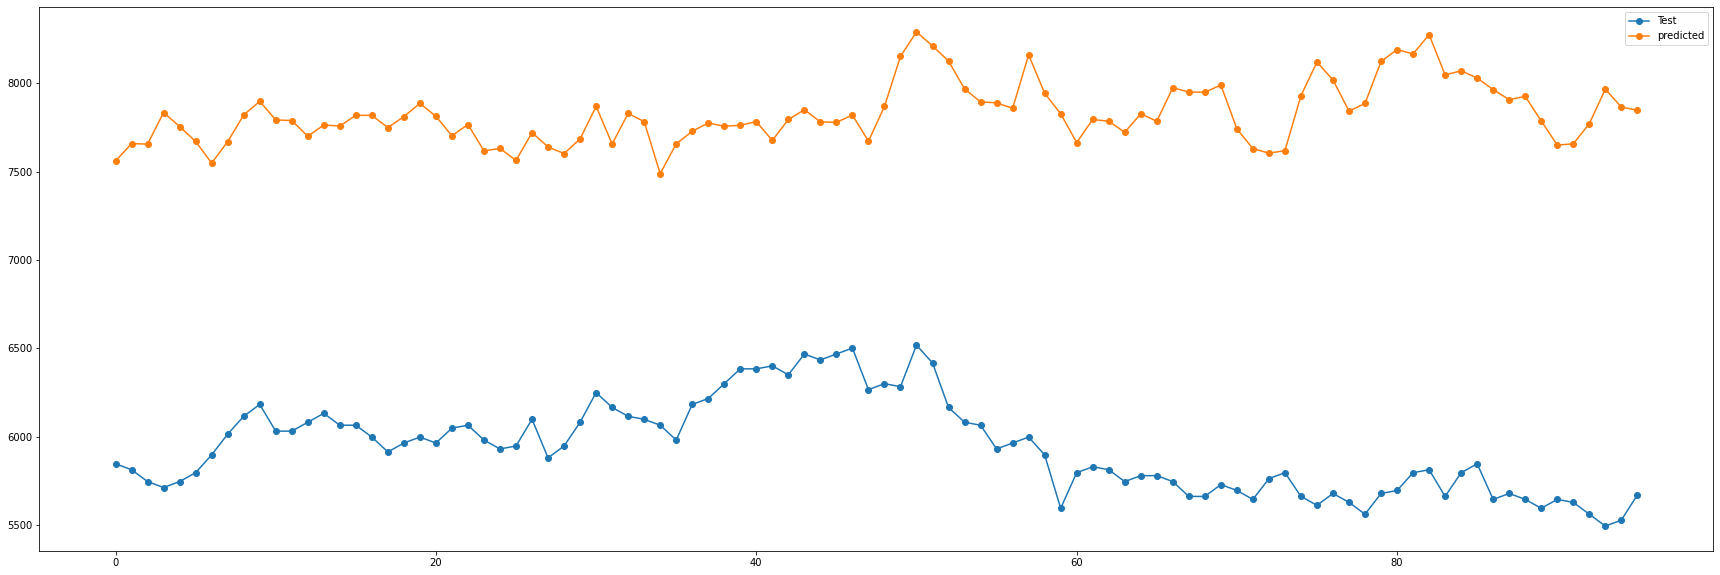

In [26]:
# predict, real 비교 plot
NP.predict_graph(dd['y_x'],dd['yhat1'])

In [18]:
# model save to disk
import pickle

filename = '/home/ykkim/Trained_Model/NeuralProphet_moorim_try2.sav'
pickle.dump(model, open(filename, 'wb'))